# SOLAQUA Video Generation Pipeline Analysis

This notebook provides individual visualizations for each step of the **actual video generation pipeline** used in `create_enhanced_contour_detection_video_with_processor()`.

The functionality has been moved to `utils.pipeline_visualization` for better organization and reusability.

In [1]:
# Import the pipeline visualization utilities
from utils.pipeline_visualization import PipelineVisualizer, run_pipeline_analysis

print("SOLAQUA Video Generation Pipeline Analysis")
print("=" * 60)
print("✅ Pipeline visualization utilities loaded!")
print("✅ All functionality moved to utils.pipeline_visualization for better organization")

# Create visualizer instance
visualizer = PipelineVisualizer()

SOLAQUA Video Generation Pipeline Analysis
✅ Pipeline visualization utilities loaded!
✅ All functionality moved to utils.pipeline_visualization for better organization


## 1. Data Loading (Exact Video Generation Process)

STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255

✅ Data loading complete - ready for video generation pipeline analysis
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255

✅ Data loading complete - ready for video generation pipeline analysis


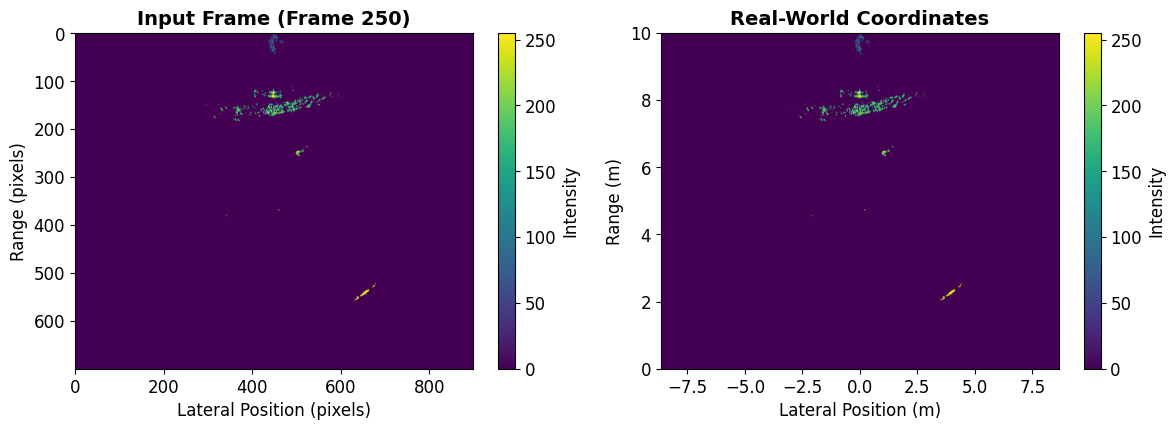

In [2]:
# STEP 1: Data Loading (Same as video generation)
npz_data_path = "/Volumes/LaCie/SOLAQUA/exports/outputs"

# Load data using the pipeline visualizer
data_loaded = visualizer.load_data(
    npz_data_path=npz_data_path,
    npz_file_index=0,
    frame_start=0,
    frame_count=100,
    frame_step=5
)

# Visualize the loaded data
visualizer.visualize_data_loading()

## 2. Processor Initialization (Exact Video Generation Setup)

In [3]:
# STEP 2: Processor Initialization (Same as video generation)
processor = visualizer.initialize_processor()

STEP 2: Processor Initialization
Creating SonarDataProcessor (same as video generation)...
✅ Processor tracking reset

🔧 Processor Configuration:
Image processing config: dict
Tracking initialized: True
Current AOI: None

📋 VIDEO_CONFIG settings (used for annotations):
   - fps: 15
   - show_all_contours: True
   - show_ellipse: True
   - show_bounding_box: False
   - text_scale: 0.6

📋 IMAGE_PROCESSING_CONFIG settings:
   - use_adaptive_linear_merging: True
   - adaptive_base_radius: 4
   - adaptive_max_elongation: 10
   - adaptive_linearity_threshold: 0.1
   - adaptive_angle_steps: 25
   - use_momentum_merging: True
   - momentum_search_radius: 50
   - momentum_threshold: 0.1
   - momentum_decay: 0.9
   - momentum_boost: 10.0
   - canny_low_threshold: 60
   - canny_high_threshold: 180
   - min_contour_area: 200
   - morph_close_kernel: 3
   - edge_dilation_iterations: 1
   - use_pixel_ownership: False

✅ Processor ready - same configuration as video generation system


## 3. Pipeline Step Visualizations

Individual clean figures for each processing step - ready to save for documentation.

Creating Figure 1: Edge Detection Pipeline
🔄 Adaptive linear merging: radius=4, max_elongation=10, threshold=0.1
   Testing 25 angles for linearity detection...
   Found 9041 pixels with strong linearity (>0.10)
   Found 9041 pixels with strong linearity (>0.10)
   Adaptive merging complete
   ✅ Enhancement complete: 9041 pixels used elliptical kernels
   Adaptive merging complete
   ✅ Enhancement complete: 9041 pixels used elliptical kernels
✅ Figure 1 saved: /tmp/solaqua_step1_edge_detection.png
✅ Figure 1 saved: /tmp/solaqua_step1_edge_detection.png


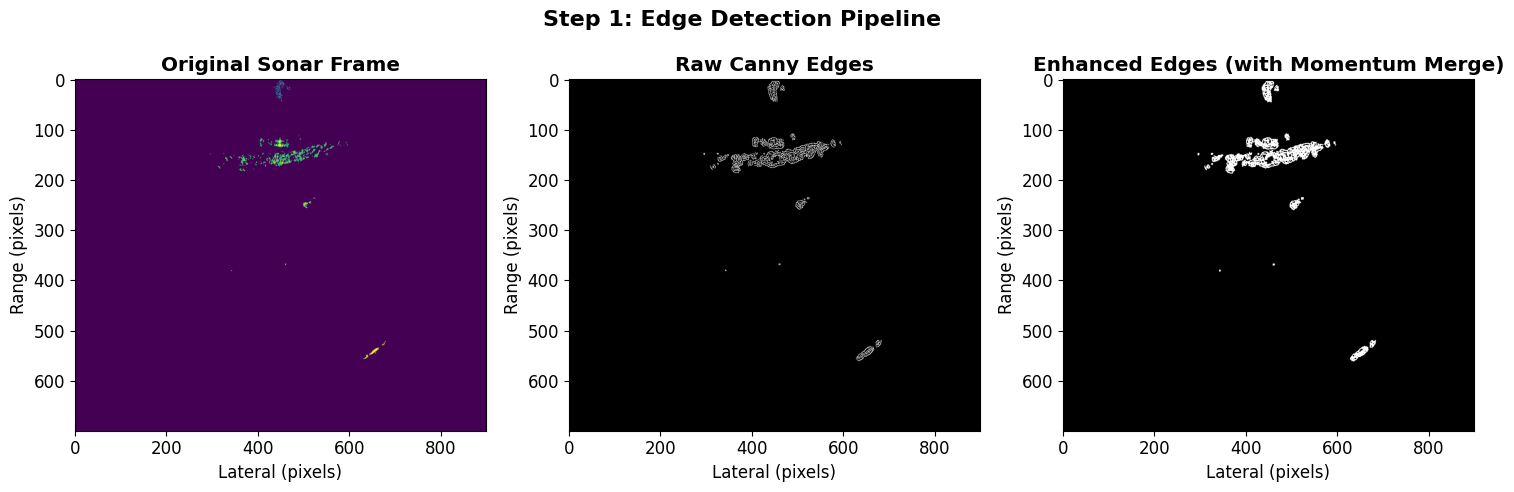

In [4]:
# Step 1: Edge Detection Pipeline
edges_raw, edges_proc = visualizer.visualize_edge_detection(
    save_path='/tmp/solaqua_step1_edge_detection.png'
)

Creating Figure 2: Contour Detection
✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png
✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png


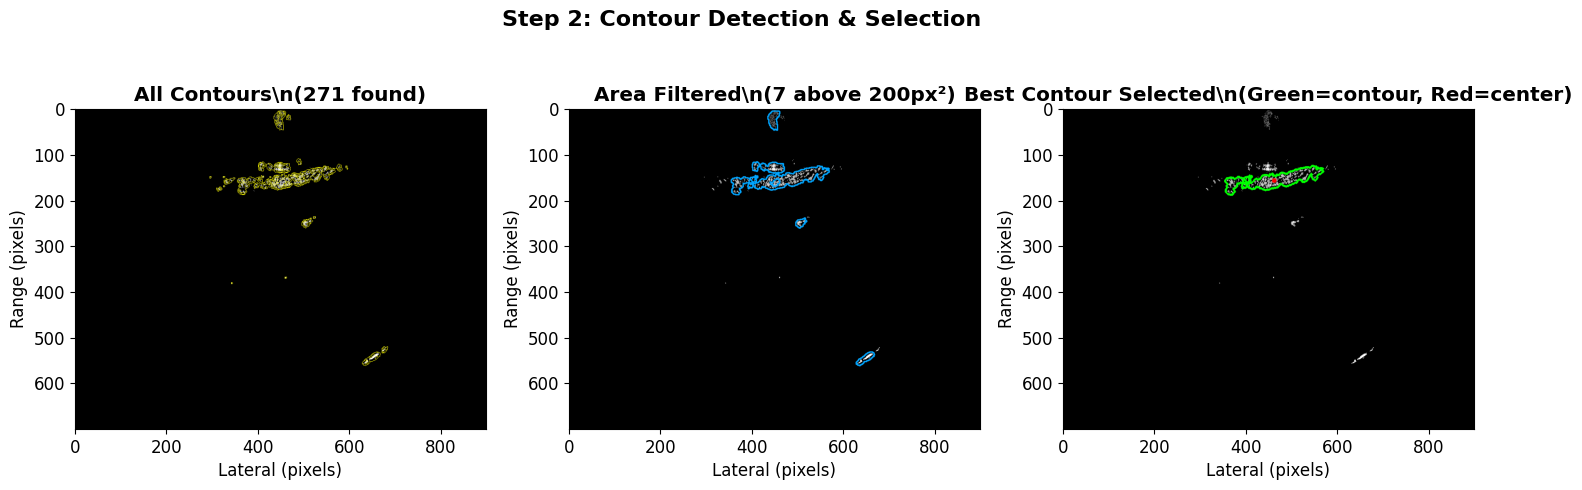

In [5]:
# Step 2: Contour Detection
contours, best_contour, features, stats = visualizer.visualize_contour_detection(
    edges_proc=edges_proc,
    save_path='/tmp/solaqua_step2_contour_detection.png'
)

In [ ]:
# Step 3: Elliptical AOI and Tracking
analysis_result = visualizer.visualize_elliptical_aoi(
    best_contour=best_contour,
    features=features,
    save_path='/tmp/solaqua_step3_elliptical_aoi.png'
)

Creating Figure 3: Elliptical AOI and Tracking
🔄 Adaptive linear merging: radius=4, max_elongation=10, threshold=0.1
   Testing 25 angles for linearity detection...
   Found 9041 pixels with strong linearity (>0.10)
   Found 9041 pixels with strong linearity (>0.10)
   Adaptive merging complete
   ✅ Enhancement complete: 9041 pixels used elliptical kernels
   Adaptive merging complete
   ✅ Enhancement complete: 9041 pixels used elliptical kernels


Creating Figure 4: Distance and Angle Measurement
Using Smoothed Center: (486.0, 150.5)
✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png
✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png


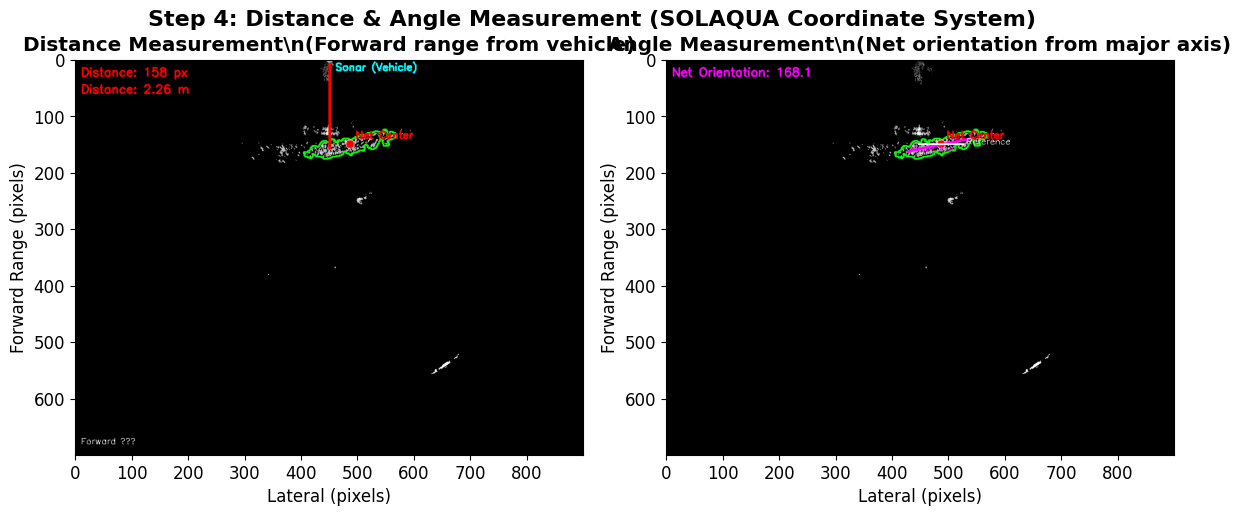

In [ ]:
# Step 4: Distance and Angle Measurement
visualizer.visualize_distance_angle_measurement(
    result=analysis_result,
    save_path='/tmp/solaqua_step4_distance_angle.png'
)

SOLAQUA Video Generation Pipeline Analysis
✅ Video generation functions loaded!
✅ Using EXACT same code as create_enhanced_contour_detection_video_with_processor()
STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255

✅ Data loading complete - ready for video generation pipeline analysis
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255

✅ Data loading complete - ready f

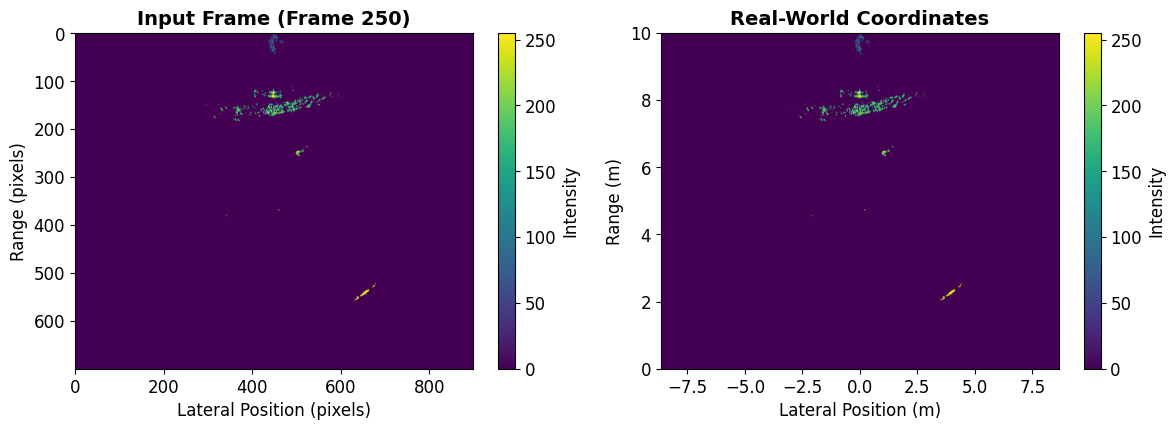

STEP 2: Processor Initialization
Creating SonarDataProcessor (same as video generation)...
✅ Processor tracking reset

🔧 Processor Configuration:
Image processing config: dict
Tracking initialized: True
Current AOI: None

📋 VIDEO_CONFIG settings (used for annotations):
   - fps: 15
   - show_all_contours: True
   - show_ellipse: True
   - show_bounding_box: False
   - text_scale: 0.6

📋 IMAGE_PROCESSING_CONFIG settings:
   - use_adaptive_linear_merging: True
   - adaptive_base_radius: 3
   - adaptive_max_elongation: 10
   - adaptive_linearity_threshold: 0.1
   - adaptive_angle_steps: 18
   - use_momentum_merging: True
   - momentum_search_radius: 50
   - momentum_threshold: 0.1
   - momentum_decay: 0.9
   - momentum_boost: 10.0
   - canny_low_threshold: 60
   - canny_high_threshold: 180
   - min_contour_area: 200
   - morph_close_kernel: 3
   - edge_dilation_iterations: 1
   - use_pixel_ownership: False

✅ Processor ready - same configuration as video generation system
Creating Figure 

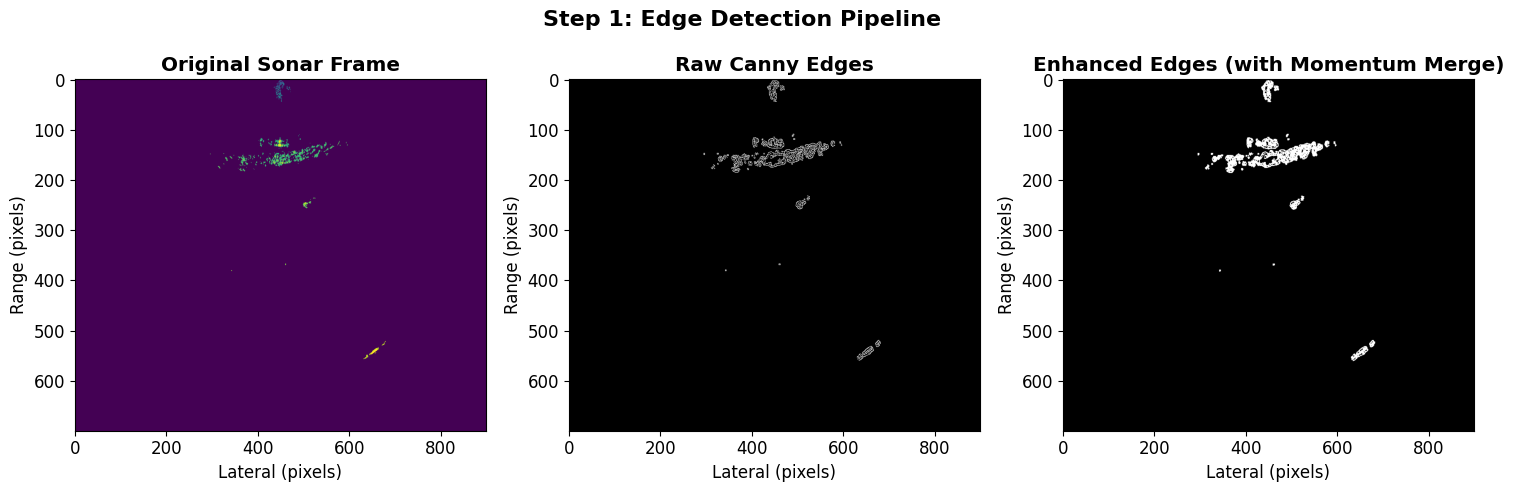

Creating Figure 2: Contour Detection
✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png
✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png


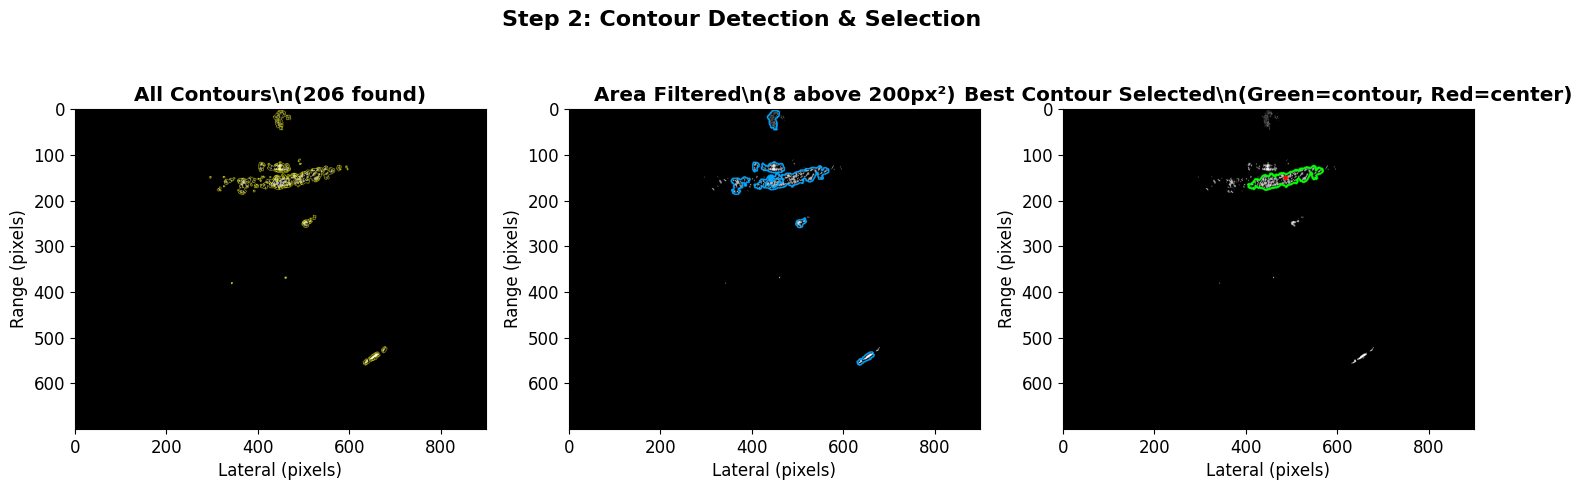

Creating Figure 3: Elliptical AOI and Tracking
🔄 Adaptive linear merging: radius=3, max_elongation=10, threshold=0.1
   Testing 18 angles for linearity detection...
   Found 8238 pixels with strong linearity (>0.10)
   Adaptive merging complete
   ✅ Enhancement complete: 8238 pixels used elliptical kernels
   Adaptive merging complete
   ✅ Enhancement complete: 8238 pixels used elliptical kernels
✅ Figure 3 saved: /tmp/solaqua_step3_elliptical_aoi.png
✅ Figure 3 saved: /tmp/solaqua_step3_elliptical_aoi.png


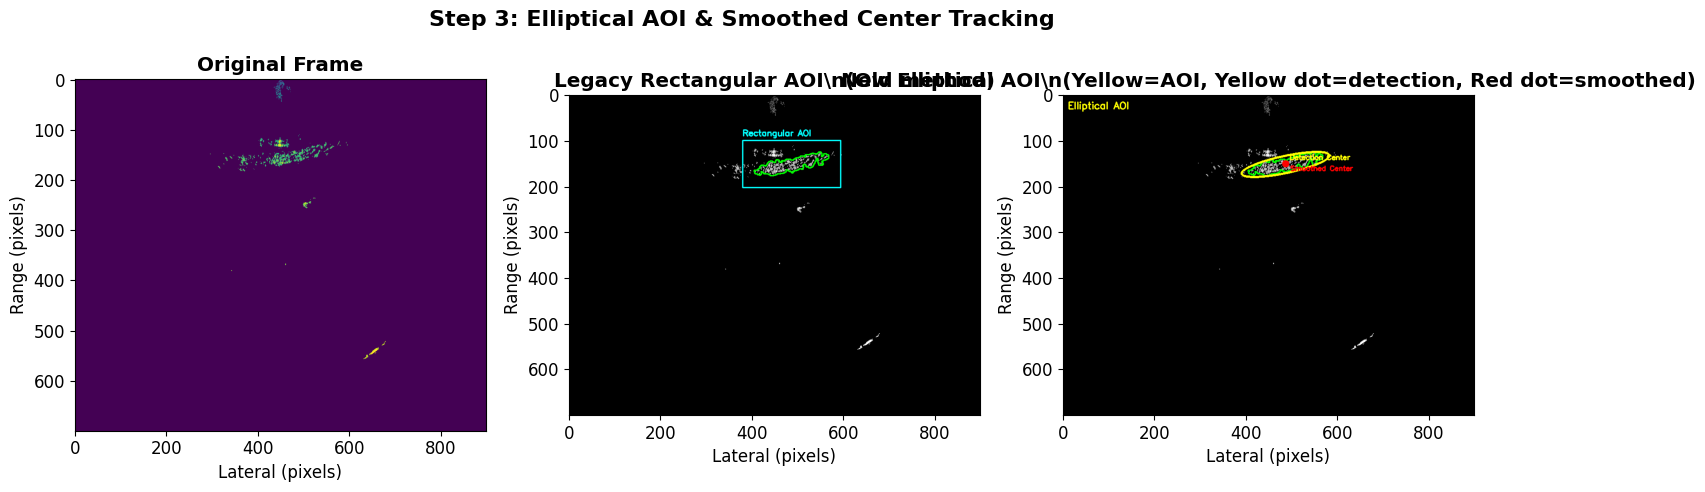

Creating Figure 4: Distance and Angle Measurement
Using Smoothed Center: (486.0, 150.5)
✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png
✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png


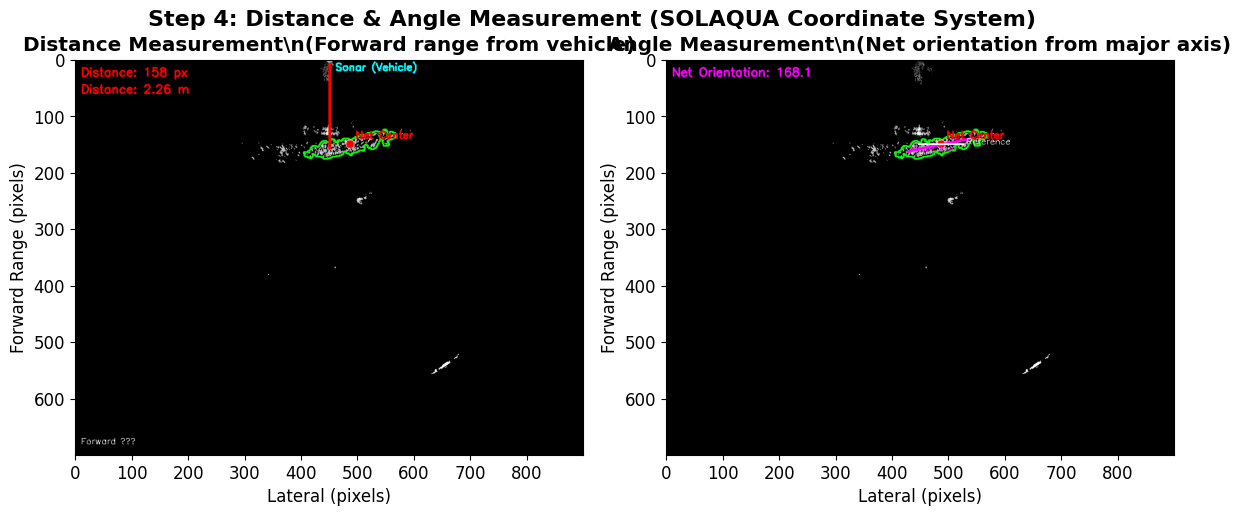

\n============================================================
✅ Complete pipeline analysis finished!
✅ All visualization figures saved to: /tmp

📊 Analysis Results Summary:
✅ Data loaded successfully: True
✅ Processor initialized: True
✅ Contours found: 206
✅ Best contour selected: True
✅ Analysis result: True


In [ ]:
# Run complete pipeline analysis in one call
# This will generate all visualizations and save them to the specified directory
results = run_pipeline_analysis(
    npz_data_path="/Volumes/LaCie/SOLAQUA/exports/outputs",
    output_dir="/tmp",
    npz_file_index=0
)

print("\n📊 Analysis Results Summary:")
print(f"✅ Data loaded successfully: {results['data_loaded']}")
print(f"✅ Processor initialized: {results['processor'] is not None}")
print(f"✅ Contours found: {len(results['contours']) if results['contours'] else 0}")
print(f"✅ Best contour selected: {results['best_contour'] is not None}")
print(f"✅ Analysis result: {results['analysis_result'].detection_success if results['analysis_result'] else False}")

## Available Functions

The `utils.pipeline_visualization` module provides the following key functions:

### `PipelineVisualizer` Class Methods:
- `load_data()` - Load NPZ data exactly as in video generation
- `initialize_processor()` - Create and configure SonarDataProcessor  
- `visualize_data_loading()` - Show input frame visualization
- `visualize_edge_detection()` - Edge detection pipeline step
- `visualize_contour_detection()` - Contour detection and selection step
- `visualize_elliptical_aoi()` - Elliptical AOI and tracking step
- `visualize_distance_angle_measurement()` - Distance and angle measurement step
- `run_complete_pipeline_analysis()` - Run all steps in sequence

### Convenience Function:
- `run_pipeline_analysis()` - One-liner to run complete analysis

All functions produce clean, publication-ready figures that can be saved to files.